# Python によるデータ分析コンテスト実践 (2)

本ドキュメントは FIT 2016 チュートリアル資料です．[Walmart Recruiting: Trip Type Classification](https://www.kaggle.com/c/walmart-recruiting-trip-type-classification) コンテストを題材として、Python のデータ分析関連パッケージの利用例を紹介する。

## 目次

* 補足：実行環境について
* Walmart Recruiting: Trip Type Classification について
  * タスク設定
  * データのダウンロード
  * データの確認
* 下準備
  * 予測モデルの交差確認
  * データセットの特徴を調べる
* 特徴量を作成する
  * 特徴量の作成
  * 中間ファイルへの保存
* 機械学習アルゴリズムを利用する
  * ロジスティック回帰モデルによる予測
  * Gradient Boosting モデルによる予測
  * 予測結果を Kaggle への投稿
* 予測モデルを改善する
  * 特徴量を増やす
  * パラメータチューニング
  * 改善した予測結果を Kaggle へ投稿

----

### 補足: 実行環境について

本チュートリアル資料で利用する実行環境は、Docker Hub に公開されている Docker イメージ [smly/notebook](https://hub.docker.com/r/smly/notebook/) を利用している。Docker がインストールされている環境で，以下のコマンドによって Jupyter notebook を立ち上げることができる．

```sh
$ docker run \
  --rm \
  -ti \
  -p 8888:8888 \
  -v /path/to/data_directory:/mnt \
  -v /path/to/working_directory:/home/kohei/work \
  smly/notebook
```

インストールされている Python パッケージのバージョン、処理系のバージョンは以下の通りである。

In [27]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import os
import sys
import warnings
import sklearn
import xgboost

# System environment
uname = os.uname()
print(f"System: {uname.sysname} {uname.machine} (kernel={uname.release})")
print(f"Python version: {sys.version}")
print(f"NumPy={np.__version__}, Pandas={pd.__version__}, ScikitLearn={sklearn.__version__}")

System: Linux x86_64 (kernel=4.4.15-moby)
Python version: 3.6.0a2 (default, Jun 28 2016, 22:42:53) 
[GCC 5.3.1 20160413]
NumPy=1.11.1, Pandas=0.18.1, ScikitLearn=0.17.1


-----

## Walmart Recruiting: Trip Type Classification について

### タスク設定

Kaggle は過去のデータ分析コンテストの終了後でも、コンテストによってはデータのダウンロードや予測結果の提出を行うことができる。
今回は Walmart TripType Classification を題材して扱う。

タスクは買い物客の「買い物かご」データから、購買行動を 38 クラスのカテゴリに分類する問題である。評価指標は Multi Log-loss である。

### データのダウンロード

以下のページよりデータをダウンロードすることができる。train, test, sampleSubmission の３つのファイルが提供されている。

訓練事例データ `train.csv` の各データフィールドは以下の通り。

|_ name _|_ Description _|
|--------|---------------|
| TripType | a categorical id representing the type of shopping trip the customer made. This is the ground truth that you are predicting. TripType_999 is an "other" category. |
| VisitNumber | an id corresponding to a single trip by a single customer |
| Weekday | the weekday of the trip |
| ScanCount | the number of the given item that was purchased. A negative value indicates a product return. |
| DepartmentDescription | a high-level description of the item's department |
| FinelineNumber | a more refined category for each of the products, created by Walmart |

### データの確認

まず CSV ファイルのデータを読み込み、内容を確認する。以下の項目を確認する：

* 訓練データでは訪問客（VisitNumber）の買い物かご履歴と、訪問客に対応するカテゴリ（TripType）が与えられている。
* テストデータではカテゴリが与えられていない。テストデータのカテゴリを訓練データに基づいて予測することが与えられたタスクである。
* 予測結果の提出フォーマットは訪問客番号と各カテゴリを列としたテーブル。訪問客番号ごとにカテゴリに属する確率を解答する。

In [3]:
import pandas as pd
import numpy as np

# 訓練データとテストデータをロードする
df_train = pd.read_csv('/mnt/train.csv')
df_test = pd.read_csv('/mnt/test.csv')
# 訓練データを確認
df_train.head()

,TripType,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber
0,999,5,Friday,6.811315e+10,-1,FINANCIAL SERVICES,1000.0
1,30,7,Friday,6.053882e+10,1,SHOES,8931.0
2,30,7,Friday,7.410811e+09,1,PERSONAL CARE,4504.0
3,26,8,Friday,2.238404e+09,2,PAINT AND ACCESSORIES,3565.0
4,26,8,Friday,2.006614e+09,2,PAINT AND ACCESSORIES,1017.0


In [4]:
# 予測結果の提出フォーマットの確認
df_sub = pd.read_csv("/mnt/sample_submission.csv")
df_sub.head()

,VisitNumber,TripType_3,TripType_4,TripType_5,TripType_6,TripType_7,TripType_8,TripType_9,TripType_12,TripType_14,...,TripType_36,TripType_37,TripType_38,TripType_39,TripType_40,TripType_41,TripType_42,TripType_43,TripType_44,TripType_999
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### 与えられたデータの傾向を調べる

データフレームを操作してクラスカテゴリごとの事例数の分布を確認する。

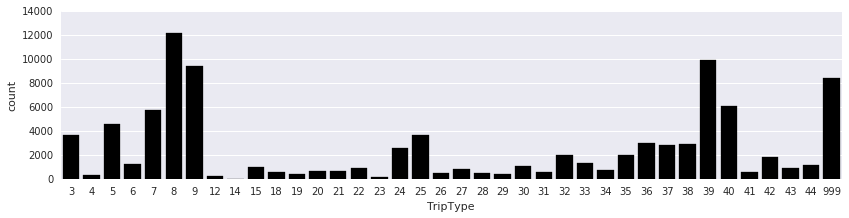

In [90]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(14, 3))
sns.countplot(x="TripType", data=df_train.drop_duplicates(subset='VisitNumber'), color='k')

履歴データには曜日が存在する。曜日ごとにクラスの分布が異なるのかを確認し、訓練事例とテスト事例が異なる分布でないか確認する。

In [135]:
# ある VisitNumber に対して、複数の Weekday が存在しないことをチェック
df_train.groupby('VisitNumber').agg({
    'Weekday': {
        'uniq': lambda x: len(x.unique()),
    }
}).Weekday.uniq.max() == 1

True

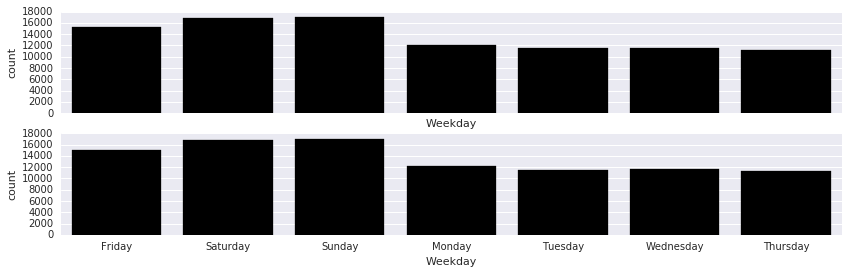

In [10]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(14, 4), sharex=True)
sns.countplot(x="Weekday", data=df_train.drop_duplicates(subset='VisitNumber'), color='k', ax=ax1)
sns.countplot(x="Weekday", data=df_test.drop_duplicates(subset='VisitNumber'), color='k', ax=ax2)

### 予測モデルの交差確認

予測モデルの性能を確認するために、今回は交差確認（cross-fold validation）を用いる。`scikt-learn.cross_validation` モジュールを使う。

評価指標の実装は `sklearn.metrics` モジュールや `ml_metrics` パッケージなどが存在する。

（補足： sklearn.metrics.log_loss 関数は「訓練事例のクラス数」と「テスト事例のクラス数」が一致しない場合はエラーとなる。多クラス分類において、希少なクラスがテスト事例に出現しないということが起こり得る。今回はこのケースに当てはまるため、パッケージを使わず自前で実装している。）

In [15]:
def multiclass_logloss(y_true, y_pred, eps=1e-15):
    """
    Ref: https://www.kaggle.com/c/predict-closed-questions-on-stack-overflow/forums/t/2644/multi-class-log-loss-function/14250#post14250
    """
    predictions = np.clip(y_pred, eps, 1-eps)
    
    # normalize row sum to 1
    predictions /= predictions.sum(axis=1)[:, np.newaxis]
    actual = np.zeros(y_pred.shape)
    rows = actual.shape[0]
    actual[np.arange(rows), y_true.astype(int)] = 1
    vsota = np.sum(actual * np.log(predictions))
    return -1.0 / rows * vsota

In [17]:
from sklearn.cross_validation import KFold
from sklearn.preprocessing import LabelEncoder


def cv_allones():
    # TripType コードを 0-indexed values (0..37) にエンコード
    y, target_index = df_train.drop_duplicates(subset='VisitNumber').TripType.factorize()
    n_classes = len(target_index.unique())           # 訓練事例の数
    n_samples = len(df_train.VisitNumber.unique())   # クラスカテゴリ数

    # 各 fold の訓練事例、テスト事例のインデックスを ndarray として返すイテレータ
    kf = KFold(n_samples, n_folds=5)
    scores = []
    for idx_train, idx_test in kf:
        y_train, y_test = y[idx_train], y[idx_test]
        y_pred = np.ones((len(y_test), n_classes))
        scores.append(multiclass_logloss(y_test, y_pred))

    # 各Fold のスコア平均
    return np.mean(scores)


score = cv_allones()
print("CV Score: {:.4f}".format(score))

CV Score: 3.6376


交差確認によって、すべてをゼロとして解答する予測を行った場合 Multi-logloss は **3.6376** となった。

訓練事例とテスト事例は時系列（曜日）が同様の分布となるようにサンプルされていることがわかる。
曜日の情報を学習モデルに特徴量として用いた場合に、訓練事例に対して過学習しないだろうと判断できる。

与えられたデータの各カテゴリカル変数の cardinality (ユニークな値の数) を調べる。これは学習アルゴリズムの選択、カテゴリカル変数のエンコーディング方法、過学習の有無などを判断する上で参考にする。

In [167]:
for col in df_train.columns:
    print("{}: {}".format(col, len(df_train[col].unique())))

TripType: 38
VisitNumber: 95674
Weekday: 7
Upc: 97715
ScanCount: 39
DepartmentDescription: 69
FinelineNumber: 5196


メモリ容量を考慮すると，DepartmentDescription ごとの集計をする pivot table は可能そうだが，FinelineNumber ごとの集計は cardinality が大きいので難しそうである．

### 特徴量を中間ファイルに保存

In [18]:
import tables as tb


def save(X, filepath):
    with tb.open_file(filepath, 'w') as f:
        atom = tb.Atom.from_dtype(X.dtype)
        filters = tb.Filters(complib='blosc', complevel=9)
        ds = f.create_carray(f.root, 'X', atom, X.shape, filters=filters)
        ds[:] = X


def load(filepath):
    with tb.open_file(filepath, 'r') as f:
        return np.array(f.root.X)


y, target_index = df_train.drop_duplicates(subset='VisitNumber').TripType.factorize()
save(y, 'triptype.h5')

### 特徴量の作成

まずは単純な特徴量セットを考える。

In [6]:
import numpy as np


def department_description_scancount():
    df = pd.pivot_table(
            pd.concat([df_train, df_test]).fillna("_NA_"),
            index="VisitNumber",
            columns=["DepartmentDescription"],
            values=["ScanCount"],
            aggfunc=[np.sum]
        )['sum']['ScanCount']

    # 訓練事例の VisitNumber, テスト事例の VisitNumber 出現順にならべる
    visit_number_order = df_train.VisitNumber.drop_duplicates().append(
            df_test.VisitNumber.drop_duplicates())

    # ゼロフィルして行列として返す
    return df.loc[visit_number_order].fillna(0).as_matrix()


save(department_description_scancount(), 'department_description_scancount.h5')

### 予測モデルを作成し、交差確認

`sklearn.linear_model` モジュールの `LogisticRegression` クラスを使い予測を行う．`fit()` メソッドの引数として，二値変数ではなく多クラス分類のクラスカテゴリ番号の `ndarray` を第二引数として与えた場合，OneVsRest として多クラス分類を解く。

In [10]:
from sklearn.linear_model import LogisticRegression


def cv_with_logistic_regression(X):
    n_samples = len(df_train.VisitNumber.unique())

    kf = KFold(n_samples, n_folds=5)
    scores = []
    for idx_train, idx_test in kf:
        y_train, y_test = y[idx_train], y[idx_test]
        X_train, X_test = X[idx_train], X[idx_test]

        clf = LogisticRegression()
        clf.fit(X_train, y_train)
        y_pred = clf.predict_proba(X_test)
        scores.append(multiclass_logloss(y_test, y_pred))
    return np.mean(scores)


X = load('department_description_scancount.h5')
print("CV Score: {:.4f}".format(cv_with_logistic_regression(X)))

[1.4798878641400788]
[1.4798878641400788, 1.500431785090141]
[1.4798878641400788, 1.500431785090141, 1.4916844082510641]
[1.4798878641400788, 1.500431785090141, 1.4916844082510641, 1.5161834370077831]
[1.4798878641400788, 1.500431785090141, 1.4916844082510641, 1.5161834370077831, 1.4793529995185901]
CV Score: 1.4935


スコアが改善し **1.4935** となった。ヘルパー関数を使う場合は以下のように扱う（※ scikit-learn 0.17 では cross_val_score は predict メソッドを呼び出すという制約があるためクラスを新たに定義するワークアラウンドを用いている。0.18 では method パラメータを指定することで predict_proba を呼び出すことができる見込みである ref: https://twitter.com/chris_bour/status/725308500834942976）

In [97]:
from sklearn.metrics import make_scorer
from sklearn.cross_validation import cross_val_score
from sklearn.linear_model import LogisticRegression


X = load('department_description.h5')
y = load('triptype.h5')
X = X[:y.shape[0]]


class LogisticRegressionForCV(LogisticRegression):
    def predict(self, X):
        return LogisticRegression.predict_proba(self, X)


clf = LogisticRegressionForCV()

n_samples = len(df_train.VisitNumber.unique())
kf = KFold(n_samples, n_folds=5)
scores = cross_val_score(clf, X, y, cv=kf, scoring=make_scorer(multiclass_logloss))
print("CV Score: {:.4f}".format(np.mean(scores)))

CV Score: 1.4934


In [26]:
def cv_with_xgboost(X):
    n_classes = len(target_index.unique())
    n_samples = len(df_train.VisitNumber.unique())
    kf = KFold(n_samples, n_folds=5)
    scores = []
    for idx_train, idx_test in kf:
        y_train, y_test = y[idx_train], y[idx_test]
        X_train, X_test = X[idx_train], X[idx_test]
        # xgboost.DMatrix オブジェクト
        dtrain = xgboost.DMatrix(X_train, y_train)
        dtest = xgboost.DMatrix(X_test, y_test)
        watchlist = [(dtrain, 'train'), (dtest, 'valtest')]
        params = {
            'objective': 'multi:softprob',
            'booster': 'gbtree',
            'num_class': n_classes,
            'learning_rate': 0.1,
            'max_depth': 8,
            'subsample': 0.9,
            'colsample_bytree': 0.8,
            'seed': 9,
            'silent': 1,
            'eval_metric': 'mlogloss',
        }
        n_estimators = 100
        gbm = xgboost.train(params, dtrain, n_estimators, evals=watchlist, verbose_eval=True)
        y_pred = gbm.predict(dtest)
        scores.append(multiclass_logloss(y_test, y_pred))
    return np.mean(scores)


y = load('triptype.h5')
X = load('department_description_scancount.h5')
score = cv_with_xgboost(X)
print("CV Score: {:.4f}".format(score))

[0]	train-mlogloss:3.173320	valtest-mlogloss:3.196157
[1]	train-mlogloss:2.885077	valtest-mlogloss:2.917132
[2]	train-mlogloss:2.637281	valtest-mlogloss:2.672605
[3]	train-mlogloss:2.483368	valtest-mlogloss:2.523364
[4]	train-mlogloss:2.344342	valtest-mlogloss:2.391242
[5]	train-mlogloss:2.230872	valtest-mlogloss:2.284210
[6]	train-mlogloss:2.128484	valtest-mlogloss:2.187200
[7]	train-mlogloss:2.039099	valtest-mlogloss:2.103906
[8]	train-mlogloss:1.963105	valtest-mlogloss:2.032676
[9]	train-mlogloss:1.895690	valtest-mlogloss:1.969344
[10]	train-mlogloss:1.833731	valtest-mlogloss:1.912244
[11]	train-mlogloss:1.778862	valtest-mlogloss:1.862115
[12]	train-mlogloss:1.727549	valtest-mlogloss:1.814620
[13]	train-mlogloss:1.681378	valtest-mlogloss:1.771903
[14]	train-mlogloss:1.634287	valtest-mlogloss:1.728659
[15]	train-mlogloss:1.593287	valtest-mlogloss:1.691280
[16]	train-mlogloss:1.554923	valtest-mlogloss:1.656863
[17]	train-mlogloss:1.521078	valtest-mlogloss:1.626221
[18]	train-mlogloss:

CV Score: 1.0494


[99]	train-mlogloss:0.796804	valtest-mlogloss:1.049420


### 予測結果の投稿

「テスト事例」に対して予測を行い、Kaggle への投稿フォーマットにあわせて投稿する。

In [28]:
def test_with_xgboost(X, y_train):
    X_train, X_test = X[:y_train.shape[0]], X[y_train.shape[0]:]

    dtrain = xgboost.DMatrix(X_train, y_train)
    dtest = xgboost.DMatrix(X_test)
    watchlist = [(dtrain, 'train')]
    params = {
        'objective': 'multi:softprob',
        'booster': 'gbtree',
        'num_class': 38,
        'learning_rate': 0.1,
        'max_depth': 8,
        'subsample': 0.9,
        'colsample_bytree': 0.8,

        'seed': 9,
        'silent': 1,
        'eval_metric': 'mlogloss',
    }
    n_estimators = 100
    gbm = xgboost.train(params, dtrain, n_estimators, evals=watchlist, verbose_eval=False)
    return gbm.predict(dtest)


X = load('department_description.h5')
y_train = load('triptype.h5')
y_pred = test_with_xgboost(X, y_train)

In [29]:
for idx, triptype in enumerate(target_index):
    df_sub['TripType_{}'.format(triptype)] = y_pred[:, idx]

df_sub.to_csv('/mnt/tutorial_xgb_v1.csv', index=False)

出力されたファイルを[投稿ページ](https://www.kaggle.com/c/walmart-recruiting-trip-type-classification/submissions/attach)からアップロードすると holdout データを使った暫定スコアが計算され，ランキングに反映される．

![](http://ho.lc/files/a51b1c29.png)

### 特徴量を増やす

In [22]:
def weekday():
    df = pd.concat([df_train, df_test]).groupby('VisitNumber').agg('first')
    visit_number_order = df_train.VisitNumber.drop_duplicates().append(
            df_test.VisitNumber.drop_duplicates())
    return df.loc[visit_number_order].Weekday.factorize()[0].reshape((-1, 1))


def n_records():
    df = pd.concat([df_train, df_test]).groupby('VisitNumber').agg('count')
    visit_number_order = df_train.VisitNumber.drop_duplicates().append(
            df_test.VisitNumber.drop_duplicates())
    return df.loc[visit_number_order].Weekday.reshape((-1, 1))


def negative_scancount_num():
    df = pd.concat([df_train, df_test]).groupby('VisitNumber').agg({
        'ScanCount': lambda x: (x < 0).sum()})
    visit_number_order = df_train.VisitNumber.drop_duplicates().append(
            df_test.VisitNumber.drop_duplicates())
    return df.loc[visit_number_order].fillna(0).ScanCount.reshape((-1, 1))


def department_description_unique_count():
    df = pd.concat([df_train, df_test]).groupby('VisitNumber').agg({
        'DepartmentDescription': lambda x: len(x.unique())})
    visit_number_order = df_train.VisitNumber.drop_duplicates().append(
            df_test.VisitNumber.drop_duplicates())
    return df.loc[visit_number_order].fillna(0).DepartmentDescription.reshape((-1, 1))


save(weekday(), 'weekday.h5')
save(n_records(), 'n_records.h5')
save(negative_scancount_num(), 'negative_scancount_num.h5')
save(department_description_unique_count(), 'department_description_unique_count.h5')

In [25]:
y = load('triptype.h5')
X = np.hstack([
    load('department_description_scancount.h5'),
    load('weekday.h5'),
    load('n_records.h5'),
    load('negative_scancount_num.h5'),
    load('department_description_unique_count.h5'),
])
X = X[:y.shape[0]]
score = cv_with_xgboost(X)
print("CV Score: {:.4f}".format(score))

[0]	train-mlogloss:2.950981	valtest-mlogloss:2.957432
[1]	train-mlogloss:2.594297	valtest-mlogloss:2.611542
[2]	train-mlogloss:2.372004	valtest-mlogloss:2.399123
[3]	train-mlogloss:2.188715	valtest-mlogloss:2.224735
[4]	train-mlogloss:2.043805	valtest-mlogloss:2.087926
[5]	train-mlogloss:1.927418	valtest-mlogloss:1.977351
[6]	train-mlogloss:1.830554	valtest-mlogloss:1.885987
[7]	train-mlogloss:1.742676	valtest-mlogloss:1.804265
[8]	train-mlogloss:1.665952	valtest-mlogloss:1.733532
[9]	train-mlogloss:1.600304	valtest-mlogloss:1.672886
[10]	train-mlogloss:1.538425	valtest-mlogloss:1.616445
[11]	train-mlogloss:1.482043	valtest-mlogloss:1.565601
[12]	train-mlogloss:1.432134	valtest-mlogloss:1.519972
[13]	train-mlogloss:1.384376	valtest-mlogloss:1.476822
[14]	train-mlogloss:1.339650	valtest-mlogloss:1.436883
[15]	train-mlogloss:1.301617	valtest-mlogloss:1.402282
[16]	train-mlogloss:1.264289	valtest-mlogloss:1.369063
[17]	train-mlogloss:1.231089	valtest-mlogloss:1.340131
[18]	train-mlogloss:

CV Score: 0.9024


[99]	train-mlogloss:0.624169	valtest-mlogloss:0.902387


交差確認のスコアが改善したため、テストセットでも改善しているか Kaggle に投稿して確認する。

In [30]:
X = np.hstack([
    load('department_description_scancount.h5'),
    load('weekday.h5'),
    load('n_records.h5'),
    load('negative_scancount_num.h5'),
    load('department_description_unique_count.h5'),
])
y_pred = test_with_xgboost(X)

for idx, triptype in enumerate(target_index):
    df_sub['TripType_{}'.format(triptype)] = y_pred[:, idx]

df_sub.to_csv('/mnt/tutorial_xgb_v2.csv', index=False)

→ 0.89